# **Fourier Neural Operator : Let's play with the operator !**


**To Do **


1.   Élément de liste
2.   Élément de liste



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/stanford_intership/mros.zip

Archive:  drive/MyDrive/stanford_intership/mros.zip
   creating: mros/
  inflating: __MACOSX/._mros         
  inflating: mros/.DS_Store          
  inflating: __MACOSX/mros/._.DS_Store  
   creating: mros/polysomnography/
  inflating: __MACOSX/mros/._polysomnography  
   creating: mros/polysomnography/edfs/
  inflating: __MACOSX/mros/polysomnography/._edfs  
  inflating: mros/polysomnography/.DS_Store  
  inflating: __MACOSX/mros/polysomnography/._.DS_Store  
   creating: mros/polysomnography/annotations-events-profusion/
  inflating: __MACOSX/mros/polysomnography/._annotations-events-profusion  
  inflating: mros/polysomnography/edfs/.DS_Store  
  inflating: __MACOSX/mros/polysomnography/edfs/._.DS_Store  
   creating: mros/polysomnography/edfs/visit1/
  inflating: __MACOSX/mros/polysomnography/edfs/._visit1  
  inflating: mros/polysomnography/annotations-events-profusion/.DS_Store  
  inflating: __MACOSX/mros/polysomnography/annotations-events-profusion/._.DS_Store  
   creating: mr

In [4]:
%%capture
pip install pytorch-lightning;

In [13]:
import os
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable


import pytorch_lightning as pl
from pytorch_lightning import Trainer
from random import randrange

In [6]:
!pip install pymatreader

  Created wheel for pymatreader: filename=pymatreader-0.0.24-cp37-none-any.whl size=8598 sha256=0625badd8e6906f60806a576ede8bf2d42ec664dd87dfa57567bc1cb441651f2
  Stored in directory: /root/.cache/pip/wheels/9b/0f/ca/b25bef5f38f5b6b4c36438f6225961d393b51a02db087fc8b1
Successfully built pymatreader


In [15]:
!pip install pyEDFlib

     |████████████████████████████████| 1.3MB 6.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.22-cp37-cp37m-linux_x86_64.whl size=1520510 sha256=6d6d1225a80f0ab353fcc20c8b688df9d32539f55f94f37aa3dc17a3c497da65
  Stored in directory: /root/.cache/pip/wheels/30/47/cc/d8725129b678c85e470f577e8fcac31e176e639deb64f9dcc1
Successfully built pyEDFlib


In [16]:
from pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from time import sleep
from IPython.display import clear_output
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation

from pyedflib import highlevel,EdfReader
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import ticker
import xml.etree.ElementTree as et
import torch


## Hyper-parameters

In [9]:
################################################################
#  data
################################################################

interesting_labels = ['C3']

path_to_edf = "/content/mros/polysomnography/edfs/visit1"
path_to_sleep_stages = "/content/mros/polysomnography/annotations-events-profusion/visit1"


################################################################
#  configurations
################################################################

ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64

## Data Generator

In [17]:
class data_generator():
    "trim night's signals to build the dataset"

    def __init__(
        self,
        root_data: str,
        root_stages: str,
        train: bool = True):
        self.root_data = root_data
        self.root_stages = root_stages
        self.train = train
        self.training_file = 'training.pt'
        self.test_file = 'test.pt'

        if not self._check_exists():
            raise RuntimeError('Dataset not found.')

        """
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        """

        # Get global structure
        list_folder_data = os.listdir(root_data)
        list_folder_stages = os.listdir(root_stages)
        N = len(list_folder_data)
        f = EdfReader(os.path.join(root_data, list_folder_data[0]))
        all_labels = f.getSignalLabels()
        interesting_channels = [idx for idx in np.arange(0,len(all_labels)) if all_labels[idx] in interesting_labels]
        freq = f.getSampleFrequencies()[interesting_channels[0]]
        c = len(interesting_labels)
        n = f.samples_in_file(interesting_channels[0])
        f.close()

        # Get signals of interest (Only C3 for now)
        data = np.zeros((N,c,n))
        for s in range(N): 
            f = EdfReader(os.path.join(root_data, list_folder_data[s]))
            for ch in np.arange(c):
                data[s,ch,:] = f.readSignal(interesting_channels[ch])
            f.close()

        # Get stages
        stages = np.zeros((N,n))
        for s in range(N): 
            my_tree = et.parse(os.path.join(root_stages, list_folder_stages[0]))
            my_root = my_tree.getroot()
            for a in my_root[4]:
                stage = int(a.text)
                for i in range(256*30):
                    stages[s,i] = stage
        
        # Check
        print('data.shape ->', data.shape)
        print('stages.shape ->', stages.shape)
        
        # Save the tensor
        if not os.path.exists('/content/drive/MyDrive/stanford_intership/Dataset'):
            os.makedirs('/content/drive/MyDrive/stanford_intership/Dataset')

        if self.train:
            torch.save(self.data, './data/MNIST_triplet/training_data.pt')
            torch.save(self.stages, './data/MNIST_triplet/training_stages.pt')
        else:
            torch.save(self.data, './data/MNIST_triplet/testing_data.pt')
            torch.save(self.stages, './data/MNIST_triplet/testing_stages.pt')

    def _check_exists(self):
        return (os.path.exists(self.root_data) and
                os.path.exists(self.root_stages))

In [18]:
data_generator(path_to_edf,path_to_sleep_stages,train=True)

ValueError: ignored

## Data Loader 

In [ ]:
class data_loader():
    def __init__(self,
                 root: str,
                 train: bool = True,
                ):
        self.root = root
        self.train = train
        self.training_file = 'training.pt'
        self.test_file = 'test.pt'
        
        if not self._check_exists():
            raise RuntimeError('Dataset not found.')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        self.data = torch.load(os.path.join(self.root, data_file))
    
    def __len__(self):
        return(len(self.data))

    def __getitem__(self,idx):
        return(self.data[idx])

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.root,self.training_file)) and
                os.path.exists(os.path.join(self.root,self.test_file)))

In [ ]:
#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [ ]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

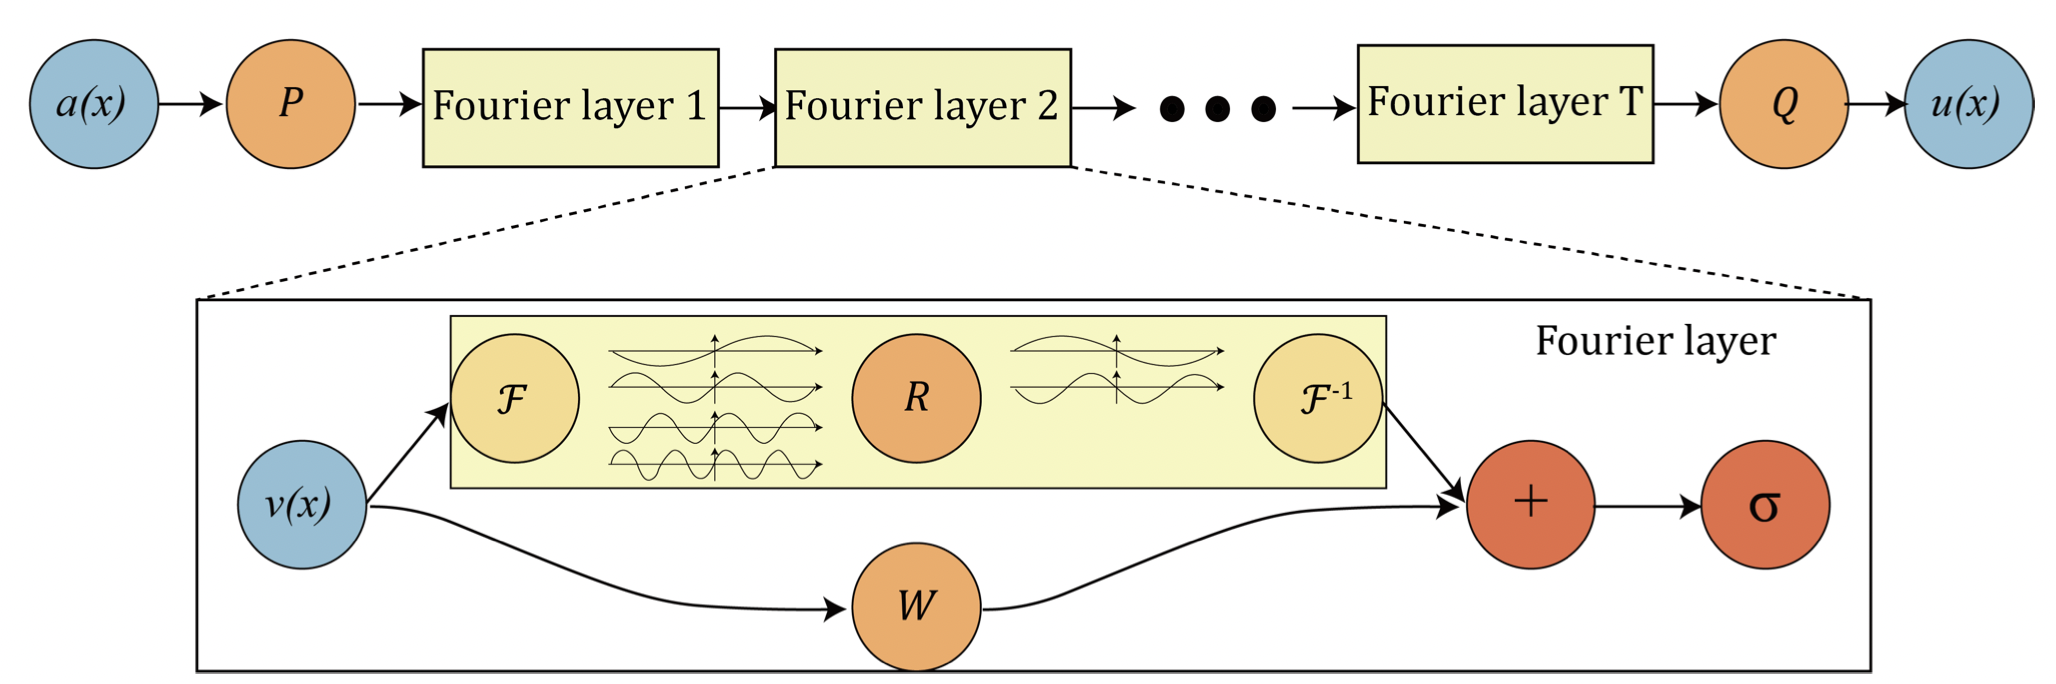

In [ ]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):

        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):        
        night = torch.unbind(batch, dim=1)
        stages = self.forward(night)
        
        loss = self.losstype.forward(stages)
        self.log('train_loss',loss)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    def train_dataloader(self):
        train_dataset = triplet_loader(root = root_for_dataset_ready,
                                       train = True,
                                       )
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=batch_size,
                                                  )
        return train_loader
    
    def validation_step(self, batch, batch_idx):
        night = torch.unbind(batch, dim=1)
        stages = self.forward(night)
        
        loss = self.losstype.forward(stages)
        self.log('val_loss',loss)
        return {'val_loss': loss}
    
    def val_dataloader(self):
        val_dataset = triplet_loader(root = root_for_dataset_ready,
                                     train = False,
                                     )
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                 batch_size=batch_size,
                                                )
        return val_loader
    
    def validation_epoch_end(self, outputs):
        self.log('avg_loss', torch.stack([x['val_loss'] for x in outputs]).mean())